In [63]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
def create_image_paths(data_dir, load_images=False, vectorize_images=False):
    '''
    Creates a list of dictionaries from the data directory.
    This also loads and vectorizes the images as another key in the dictionary if the parameter is set.
    '''
    class_data = [f"{data_dir}/{name}" for name in os.listdir(data_dir) if os.path.isdir(f"{data_dir}/{name}")]
    constructed = []
    for c in class_data:
        images = os.listdir(c)
        for im_name in images:
            im_path = f"{c}/{im_name}"
            row = {"im_path": im_path,
                                "class": c.split('/')[1]}
            if load_images:
                loaded_image = image = Image.open(im_path)
                im_arr = np.asarray(image)
                im_size = im_arr.shape
                row["im_arr"] = im_arr
                row["im_shape"] = im_size
                if vectorize_images:
                    image_vector = im_arr.reshape(1, -1, 3)
                    row['vectorized_R'] = image_vector[0, :, 0]
                    row['vectorized_G'] = image_vector[0, :, 1]
                    row['vectorized_B'] = image_vector[0, :, 2]
            constructed.append(row)
    return constructed


In [6]:
data_dir = 'dataset-resized'
data_df = pd.DataFrame(create_image_paths(data_dir, load_images=True, vectorize_images=True))

In [8]:
data_df.head()

,im_path,class,im_arr,im_shape,vectorized_R,vectorized_G,vectorized_B
0,dataset-resized/paper/paper283.jpg,paper,"[[[236, 232, 220], [236, 232, 220], [236, 232,...","(384, 512, 3)","[236, 236, 236, 236, 236, 236, 236, 236, 235, ...","[232, 232, 232, 232, 232, 232, 232, 232, 231, ...","[220, 220, 220, 220, 220, 220, 220, 220, 219, ..."
1,dataset-resized/paper/paper297.jpg,paper,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(384, 512, 3)","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ...","[255, 255, 255, 255, 255, 255, 255, 255, 255, ..."
2,dataset-resized/paper/paper526.jpg,paper,"[[[240, 240, 238], [240, 240, 238], [240, 240,...","(384, 512, 3)","[240, 240, 240, 239, 239, 238, 238, 238, 237, ...","[240, 240, 240, 239, 239, 238, 238, 238, 237, ...","[238, 238, 238, 237, 237, 236, 236, 236, 235, ..."
3,dataset-resized/paper/paper240.jpg,paper,"[[[255, 255, 255], [255, 255, 255], [255, 255,...","(384, 512, 3)","[255, 255, 255, 255, 255, 255, 254, 254, 255, ...","[255, 255, 255, 255, 255, 255, 254, 254, 255, ...","[255, 255, 255, 255, 255, 255, 254, 254, 255, ..."
4,dataset-resized/paper/paper254.jpg,paper,"[[[240, 244, 245], [240, 244, 245], [240, 244,...","(384, 512, 3)","[240, 240, 240, 240, 240, 240, 240, 240, 239, ...","[244, 244, 244, 244, 244, 244, 244, 244, 243, ...","[245, 245, 245, 245, 245, 245, 245, 245, 244, ..."


In [59]:
def plot_rgb_historgrams(img, red, green, blue, bins=256):
    plt.imshow(img)
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True,)
    axs[0].hist(red, bins=bins, color='r')
    axs[1].hist(green, bins=bins, color='g')
    axs[2].hist(blue, bins=bins, color='b')
    fig.text(0.5, -0.04, 'pixel color value [0,255]', ha='center')
    fig.text(0.04, 0.5, 'count of pixels with color value', va='center', rotation='vertical')
    plt.show()

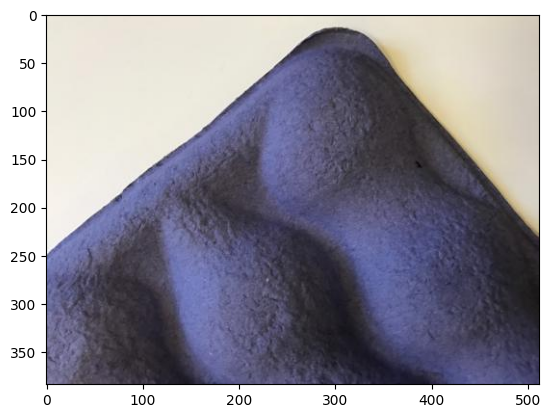

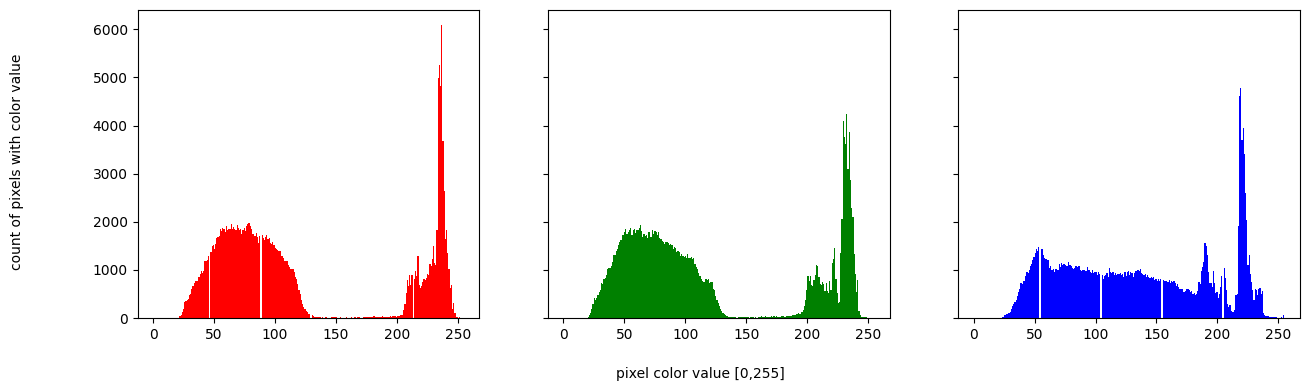

In [60]:
d = data_df.iloc[0]
plot_rgb_historgrams( d['im_arr'], d['vectorized_R'], d['vectorized_G'], d['vectorized_B'])

## Perform Basic Cosine Similarity from RGB Color Historgrams

In [80]:
def get_vector(image, bins=32):
    '''
    Use cv3 to calculate color histograms from images using the given bins
    '''
    red = cv2.calcHist(
        [image], [0], None, [bins], [0, 256]
    )
    green = cv2.calcHist(
        [image], [1], None, [bins], [0, 256]
    )
    blue = cv2.calcHist(
        [image], [2], None, [bins], [0, 256]
    )
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

def cosine(a, b):
    '''
    calculate cosine similarity between two vectors
    '''
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def search(img_vectors, idx, top_k=5):
    query_vector = img_vectors[idx]
    distances = []
    for _, vector in enumerate(img_vectors):
        distances.append(cosine(query_vector, vector))
    # get top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return top_idx

In [78]:
image_vectors = data_df['im_arr'].apply(get_vector)

In [82]:
similars = search(image_vectors, 0, top_k=5)

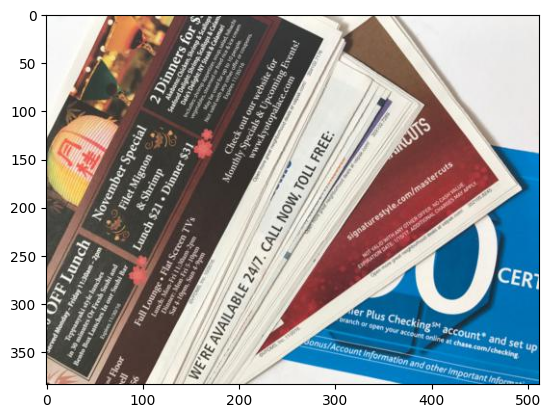

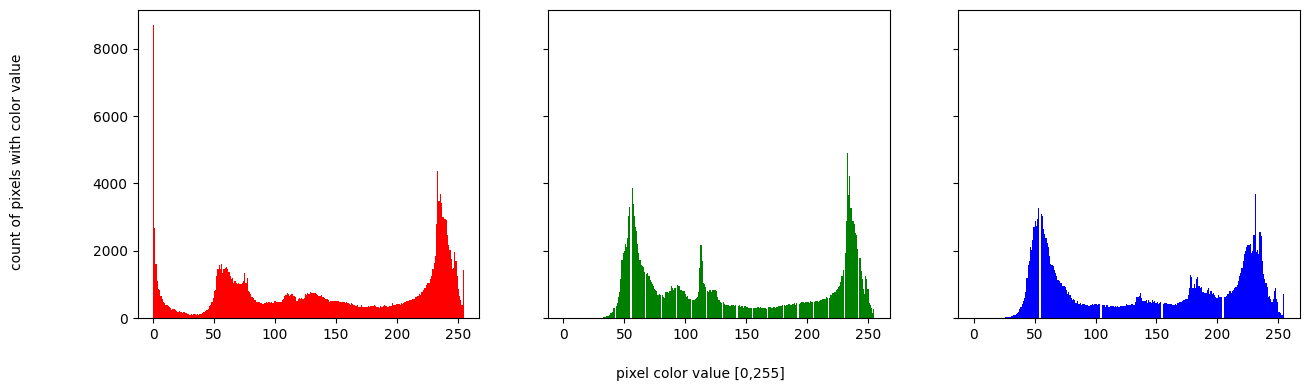

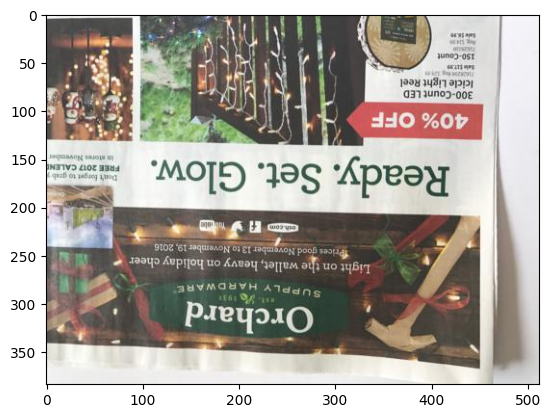

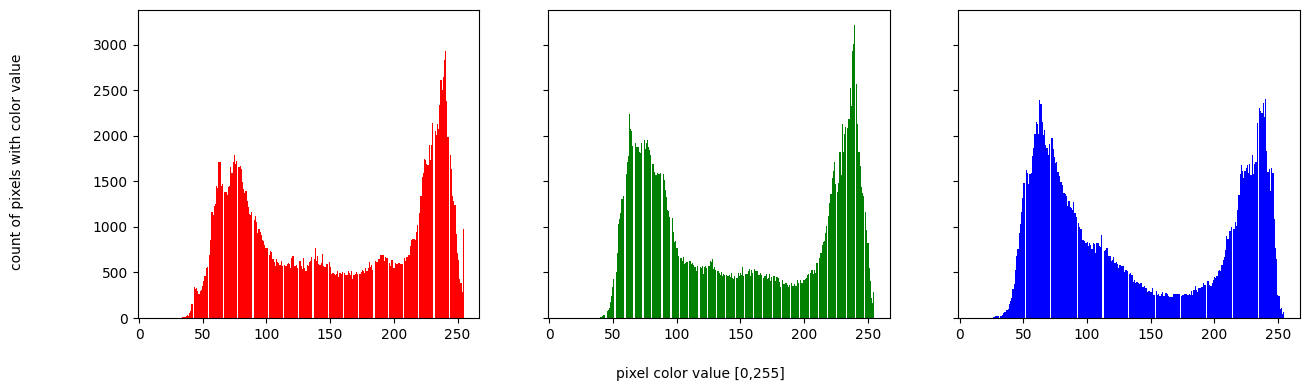

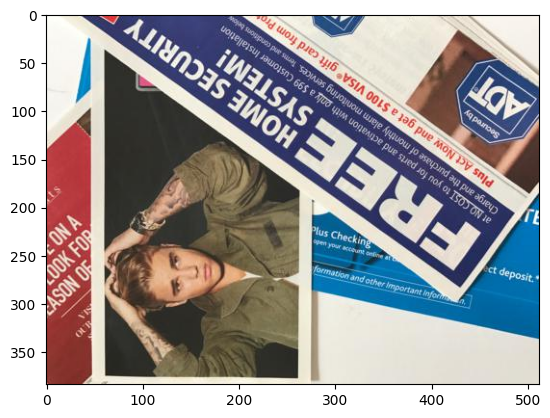

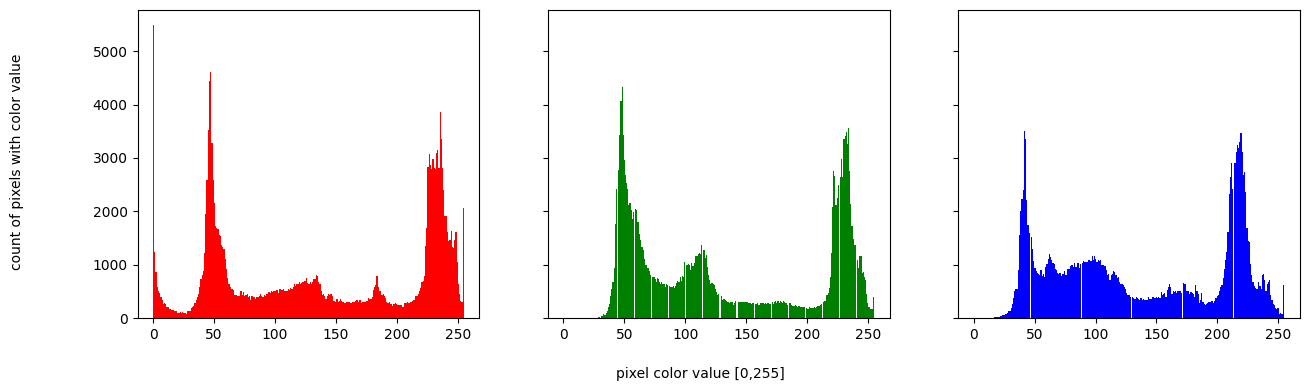

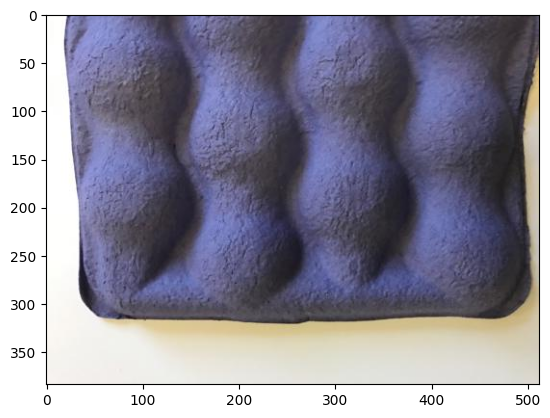

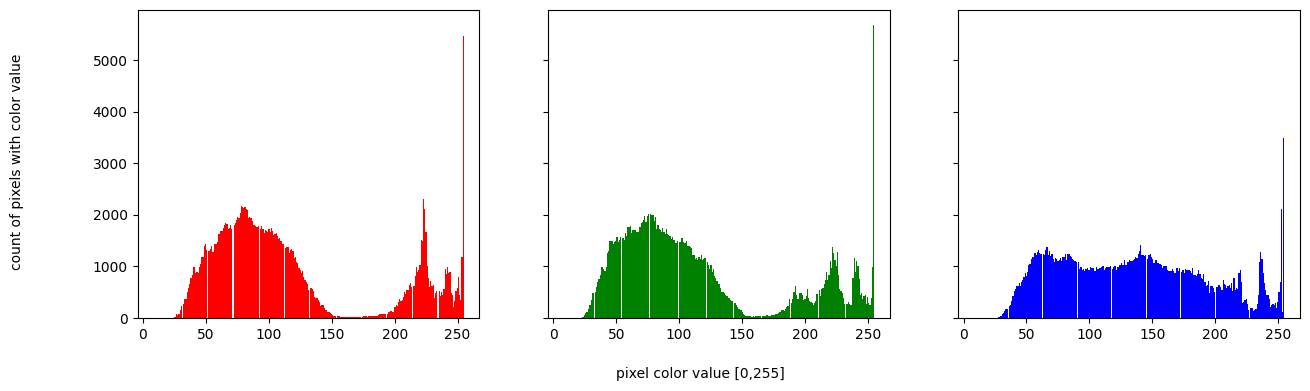

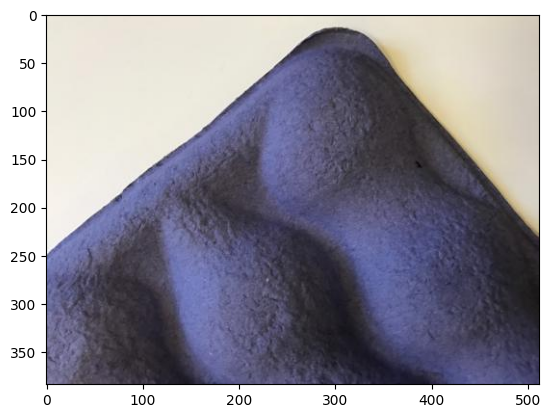

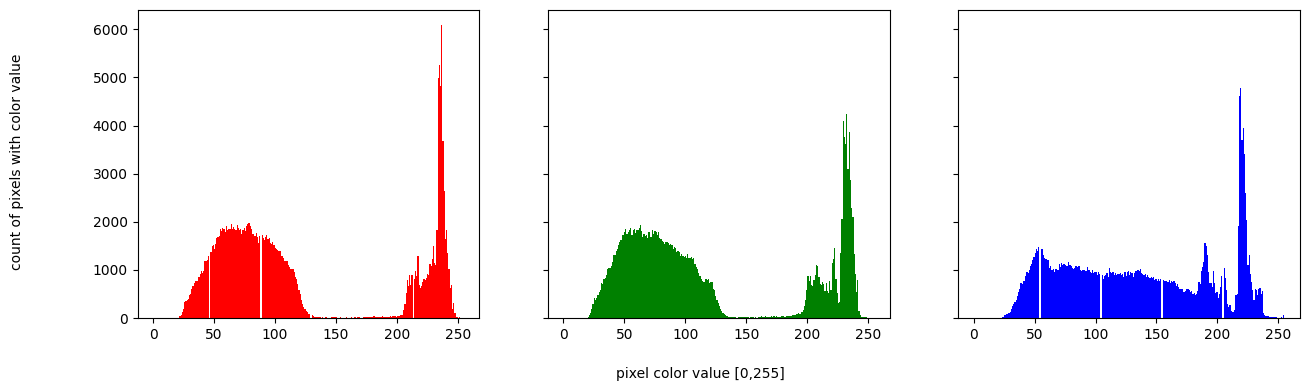

In [83]:
for c in similars:
    d = data_df.iloc[c]
    plot_rgb_historgrams( d['im_arr'], d['vectorized_R'], d['vectorized_G'], d['vectorized_B'])

## References
- [Loading images as np arrays](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
- [Color Histograms](https://www.pinecone.io/learn/color-histograms/)
- https://nbviewer.org/github/collindching/Waste-Sorter/blob/master/Waste%20sorter.ipynb